# JOSS publication figures creator
This script will create the figures that are used in the JOSS publication of the Metob-toolkit.

In [1]:
#!pip install MetObs-toolkit
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None} #else the legend is cutoff in ipython inline plots

In [2]:
import logging
import math
import os
import sys
import time
from pathlib import Path

import metobs_toolkit
print(f'Metobs_toolkit version: v{metobs_toolkit.__version__}')

import matplotlib.pyplot as plt
import pandas as pd


Metobs_toolkit version: v0.3.1


## Creation of the Dataset

In [3]:
datadf = pd.read_csv(metobs_toolkit.demo_datafile, sep=';')
metadf = pd.read_csv(metobs_toolkit.demo_metadatafile, sep=',')

# Subset to regio ghent
ghent_stations = [ 'vlinder24', 'vlinder25', 'vlinder05', 'vlinder27',
                  'vlinder02', 'vlinder01', 'vlinder28']


datadf = datadf[datadf['Vlinder'].isin(ghent_stations)]
metadf = metadf[metadf['Vlinder'].isin(ghent_stations)]

# subset period
datadf['dummy_dt'] = datadf['Datum'] + datadf['Tijd (UTC)']
datadf['dummy_dt'] = pd.to_datetime(datadf['dummy_dt'], format='%Y-%m-%d%H:%M:%S')

#Subset to period
from datetime import datetime
startdt = datetime(2022, 9, 1)
enddt = datetime(2022, 9, 10)
datadf = datadf[(datadf['dummy_dt'] >= startdt) & (datadf['dummy_dt'] <= enddt)]
datadf = datadf.drop(columns=['dummy_dt'])

# Inducing outliers as demo
datadf = datadf.drop(index=datadf.iloc[180:200, :].index.tolist())

# save in paper folder
folder = os.path.abspath('')
datadf.to_csv(os.path.join(folder, 'datafile.csv'))
metadf.to_csv(os.path.join(folder, 'metadatafile.csv'))

#Importing raw data
use_dataset = 'paper_dataset'
dataset = metobs_toolkit.Dataset()
dataset.update_output_dir(folder)
dataset.update_file_paths(input_data_file=os.path.join(folder, 'datafile.csv'),
                        input_metadata_file=os.path.join(folder, 'metadatafile.csv'),
                        template_file=metobs_toolkit.demo_template,
                        )

dataset.import_data_from_file()

Unnamed: 0 is present in the datafile, but not found in the template! This column will be ignored.


Luchtdruk is present in the datafile, but not found in the template! This column will be ignored.


Neerslagintensiteit is present in the datafile, but not found in the template! This column will be ignored.


Neerslagsom is present in the datafile, but not found in the template! This column will be ignored.


Rukwind is present in the datafile, but not found in the template! This column will be ignored.


Luchtdruk_Zeeniveau is present in the datafile, but not found in the template! This column will be ignored.


Globe Temperatuur is present in the datafile, but not found in the template! This column will be ignored.


The following columns are found in the metadata, but not in the template and are therefore ignored: 
['sponsor', 'Network', 'Unnamed: 0', 'benaming', 'stad']


## Styling settings

In [4]:
# change color for printing (avoid yellow!)
from metobs_toolkit.settings_files.default_formats_settings import label_def

label_def['gross_value']['color'] = "#fc0303"

## Timeseries for each station

A 0 days 00:00:00 is given as an argument for a timedelta.


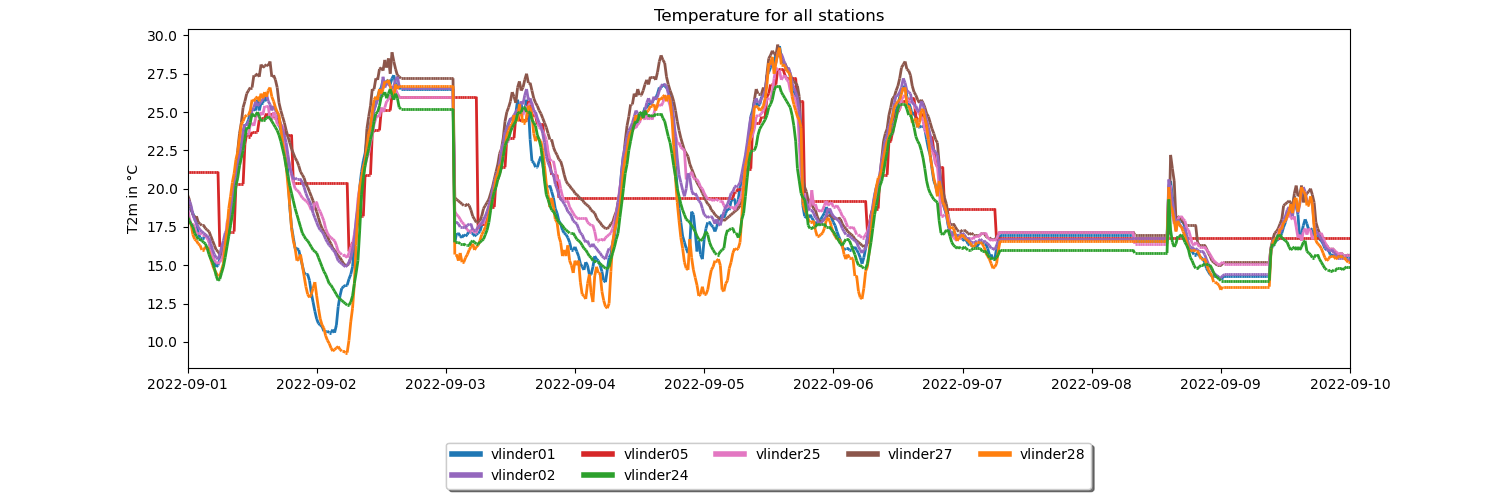

In [5]:
#1. Coarsen resolution and apply quality control with non-defaults as demonstration
dataset.coarsen_time_resolution(freq='20min')

ax1 = dataset.make_plot()

#translate axes
ax1.set_title('Temperature for all stations')
ax1.set_ylabel('T2m in °C')
plt.show()

## Timeseries with quality control labels

The windows are too small for stations  ['vlinder01', 'vlinder02', 'vlinder05', 'vlinder24', 'vlinder25', 'vlinder27', 'vlinder28'] to perform persistence check


buddy radius for the TITAN buddy check updated:  50000--> 10000.0
buddy num min for the TITAN buddy check updated:  2--> 3
buddy threshold for the TITAN buddy check updated:  1.5--> 2.2
buddy min std for the TITAN buddy check updated:  1.0--> 1.0


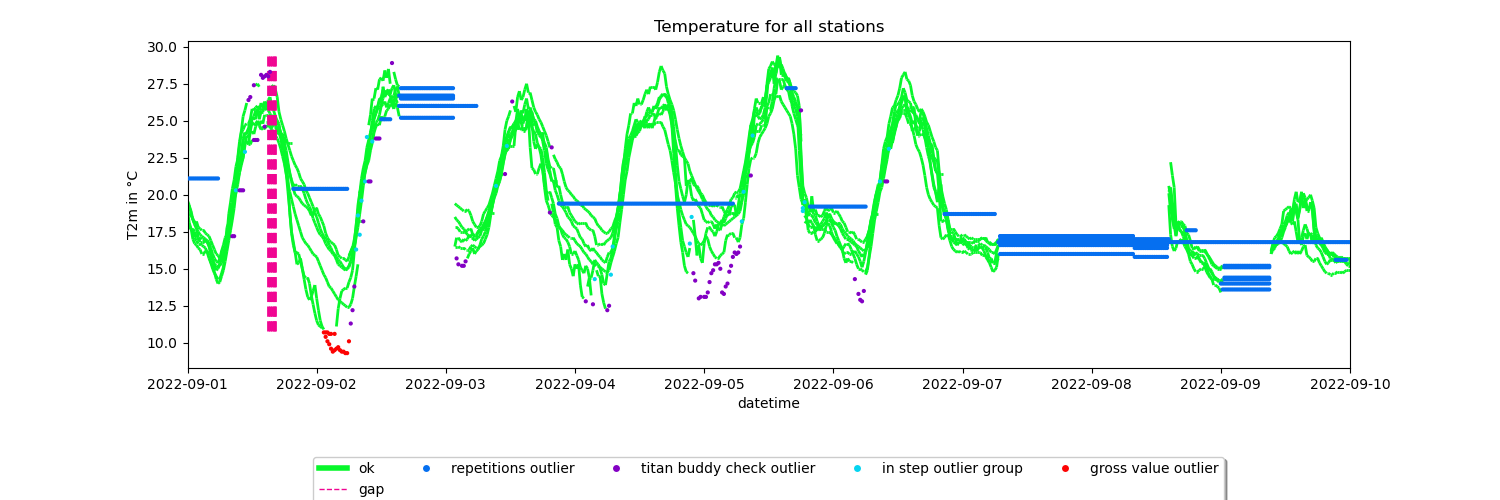

In [6]:
#update QC settings
dataset.update_qc_settings(obstype='temp',
                           dupl_timestamp_keep=None,
                           persis_time_win_to_check=None,
                           persis_min_num_obs=None,
                           rep_max_valid_repetitions=None,
                           gross_value_min_value=10.7,
                           gross_value_max_value=None,
                           win_var_max_increase_per_sec=None,
                           win_var_max_decrease_per_sec=None,
                           win_var_time_win_to_check=None,
                           win_var_min_num_obs=None,
                           step_max_increase_per_sec=5./3600.,
                           step_max_decrease_per_sec=None)

dataset.update_titan_qc_settings(obstype='temp', buddy_radius=10000,
                                   buddy_num_min=3, buddy_threshold=2.2,
                                   buddy_max_elev_diff=None,
                                   buddy_elev_gradient=None,
                                   buddy_min_std=1.0,
                                   buddy_num_iterations=None,
                                   buddy_debug=None)

dataset.apply_quality_control()
dataset.apply_titan_buddy_check(use_constant_altitude=True)

# Create the plot
ax2 = dataset.make_plot(colorby='label')
#translate axes
ax2.set_title('Temperature for all stations')
ax2.set_ylabel('T2m in °C')

plt.show()

## Fill gaps and plot timeseries of Vlinder28

The current gaps will be removed and new gaps are formed!


Cannot fill temp-gap of vlinder05 for 2022-09-01 00:00:00+00:00 --> 2022-09-01 05:40:00+00:00, duration: 0 days 05:40:00 or 18 records., because leading record is not valid.


Cannot fill temp-gap of vlinder05 for 2022-09-06 20:40:00+00:00 --> 2022-09-07 06:00:00+00:00, duration: 0 days 09:20:00 or 29 records., because trailing period is not valid.


Cannot fill temp-gap of vlinder05 for 2022-09-07 06:40:00+00:00 --> 2022-09-10 00:00:00+00:00, duration: 2 days 17:20:00 or 197 records., because trailing period is not valid.


/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/dataset_core.py:509: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combdf = pd.concat([df, outliersdf])  # combine the two


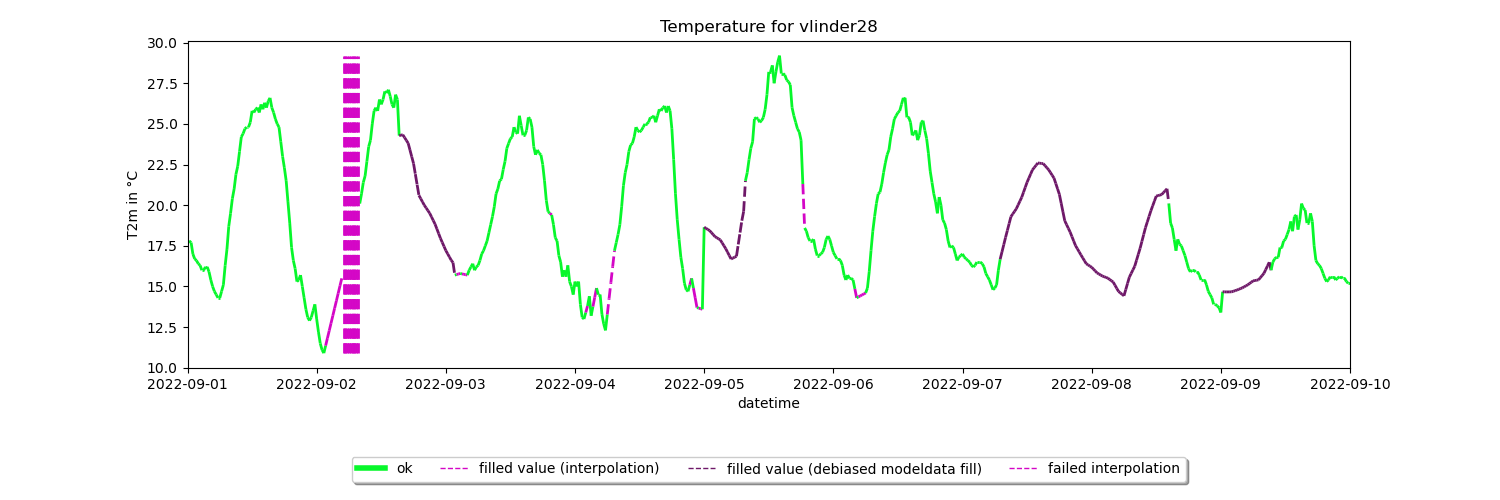

In [7]:
# 1. Convert the outliers to gaps
dataset.convert_outliers_to_gaps()

# 2. Extract ERA5 temperature timeseries at the location of the stations
era5 = dataset.get_modeldata(
                    Model=dataset.gee_datasets['ERA5-land'],
                    obstypes='temp',
                    stations=None,
                    startdt=None,
                    enddt=None,
                    force_direct_transfer=True)


# 3. Fill the gaps (For shorter gaps we use interpolation, and for longer gaps we use debiased ERA5 temperature).

short_gaps = []
long_gaps = []

for gap in dataset.gaps:
    if (gap.duration <= pd.Timedelta('6h')):
        short_gaps.append(gap)
    else:
        long_gaps.append(gap)


#interpolate the short gaps
for shortgap in short_gaps:
    shortgap.interpolate(
        Dataset=dataset,
        method="time", #Simple (weighted) linear interpolated
        max_consec_fill=10,
        n_leading_anchors=1,
        n_trailing_anchors=1,
        max_lead_to_gap_distance=None,
        max_trail_to_gap_distance=None,
        method_kwargs={})
    
# Fill the longer gaps with debiased ERA5 temperatures
for longgap in long_gaps:
    longgap.debias_model_gapfill(
        Dataset=dataset,
        Model=era5,
        leading_period_duration="24h",
        min_leading_records_total=3,
        trailing_period_duration="24h",
        min_trailing_records_total=3)
    
# 4. Make plot (of single station for clearity)
ax3 = dataset.get_station('vlinder28').make_plot(colorby='label')

#translate axes
ax3.set_title('Temperature for vlinder28')
ax3.set_ylabel('T2m in °C')

plt.show()


## Diurnal Analysis

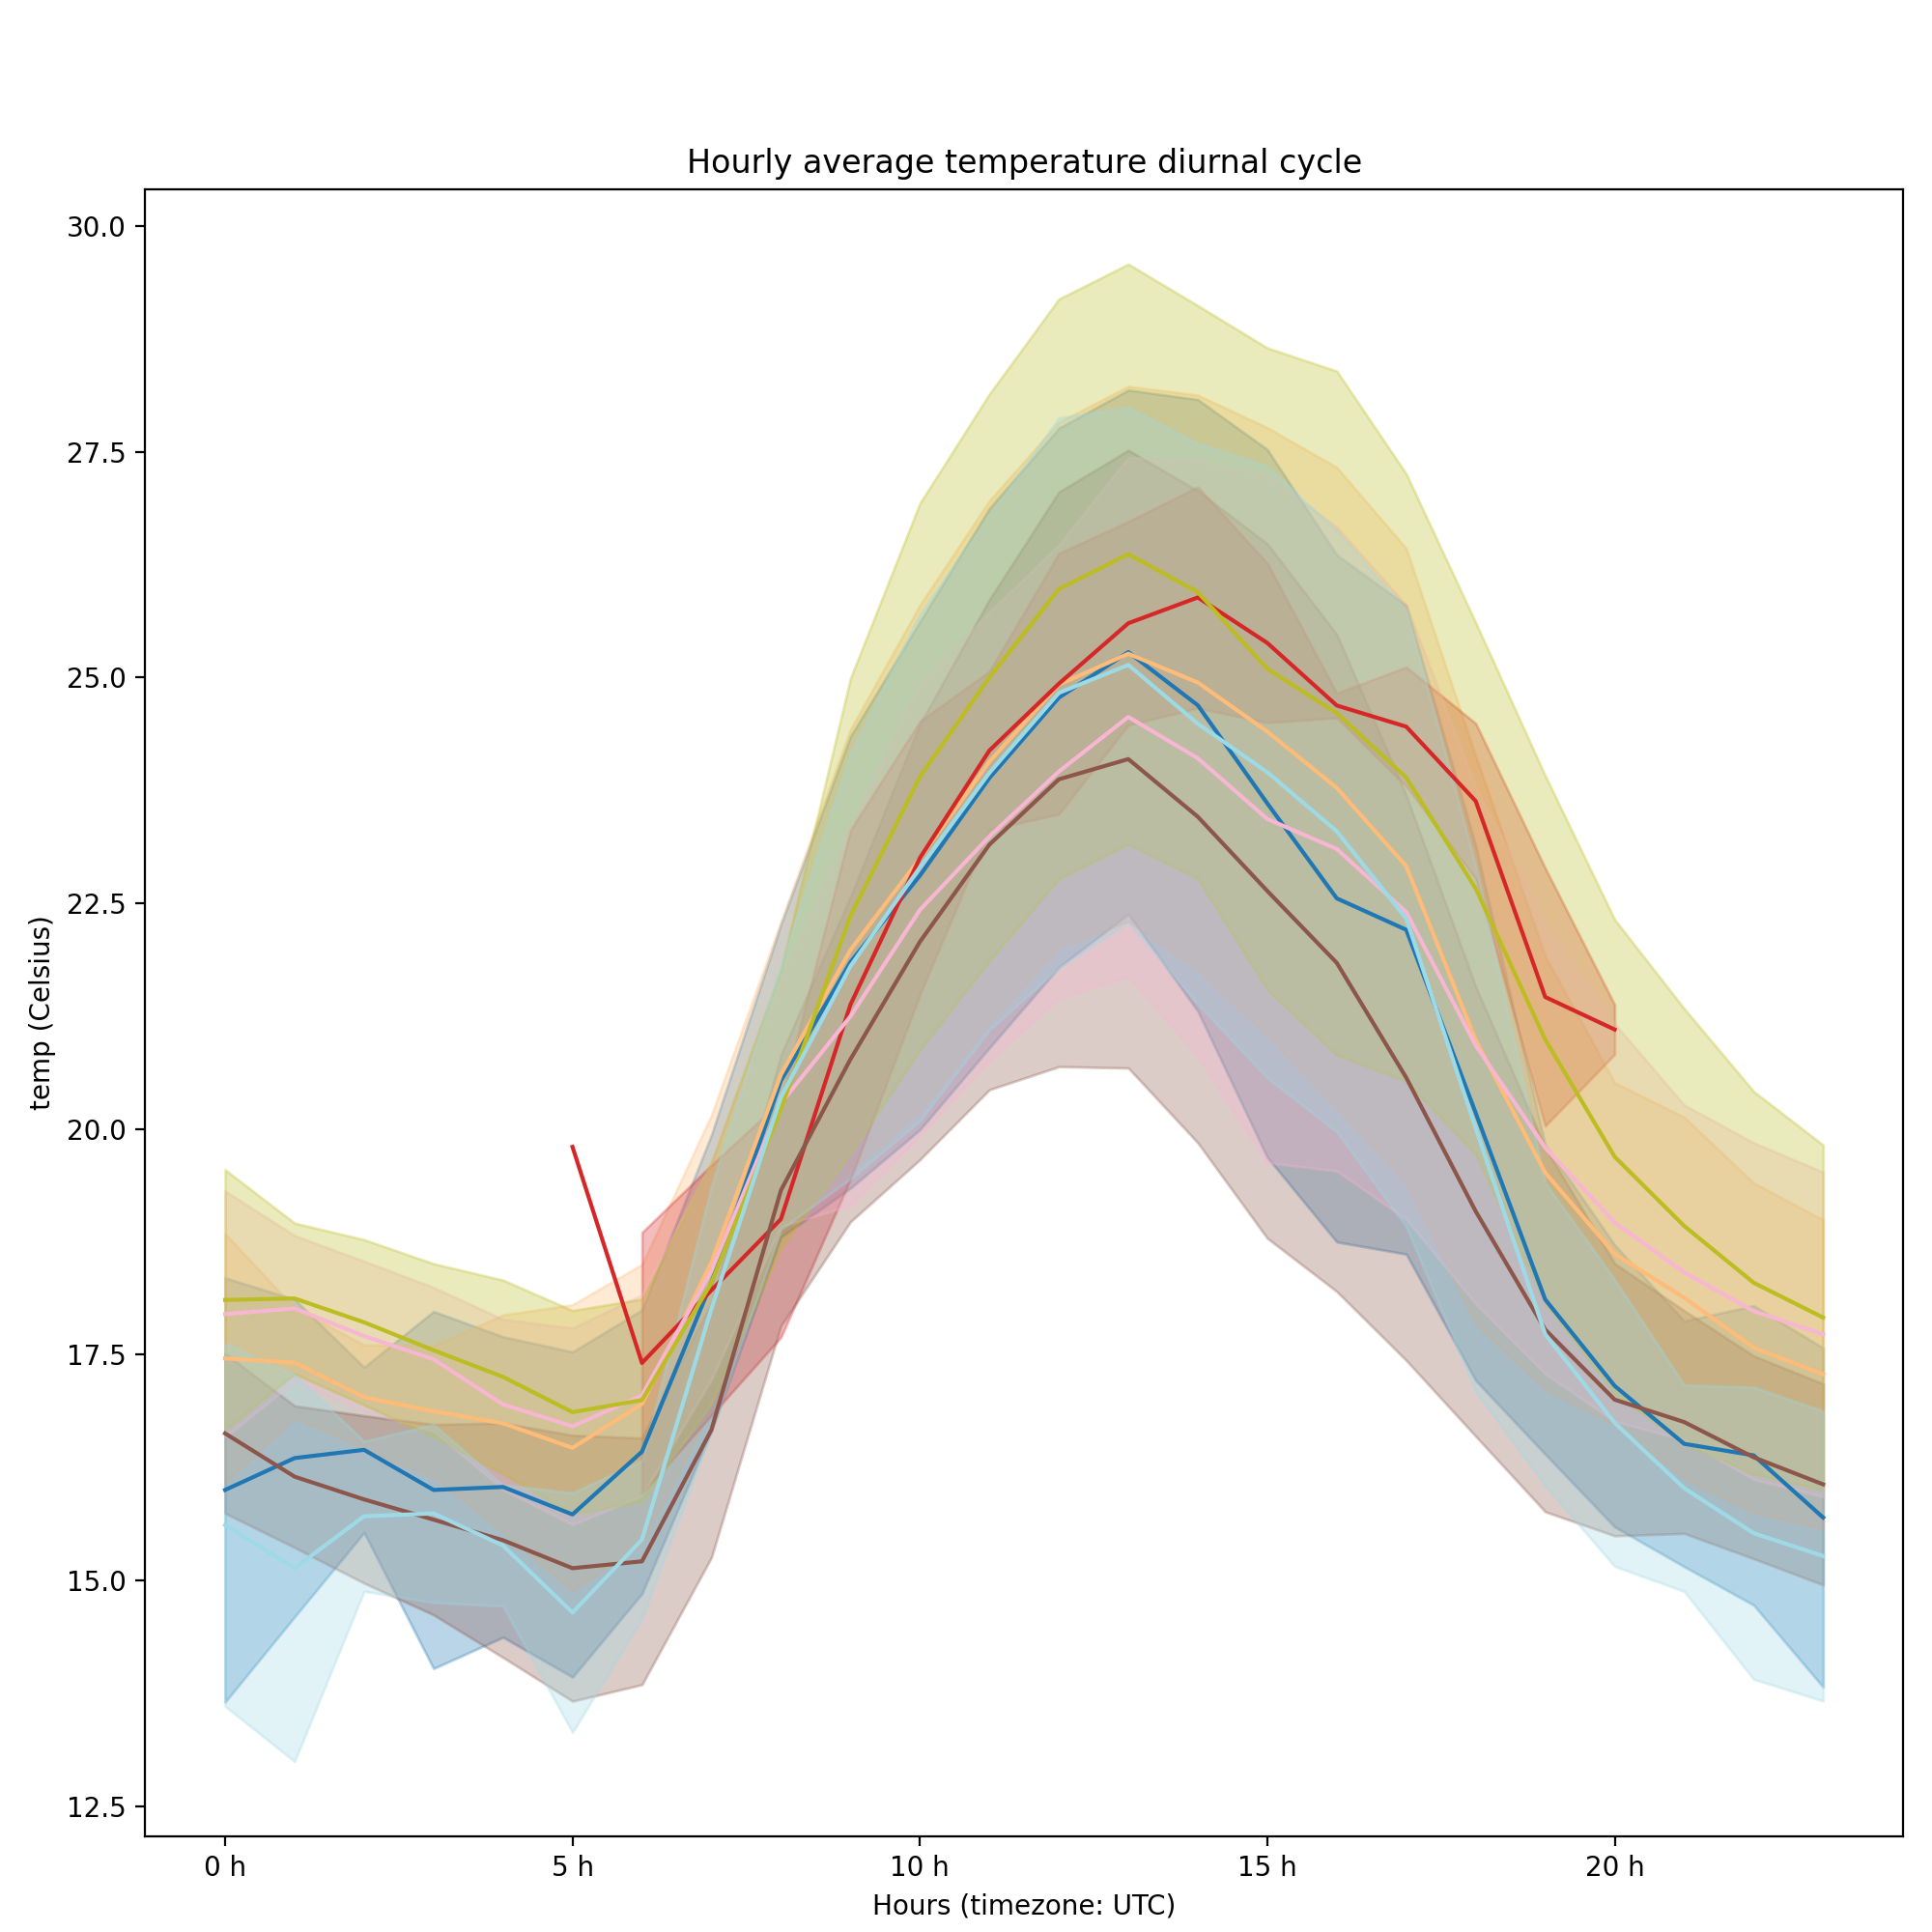

In [8]:

# Get Meta data
dataset.get_landcover(buffers=[50, 150, 500], aggregate=True)

# Create analysis from the dataset
ana = metobs_toolkit.Analysis(orig_dataset = dataset,
                              use_gapfilled_values=True)

# Make diurnal cycle analysis with plot
ax4 = ana.get_diurnal_statistics(colorby='name',
                                 obstype='temp',
                                 plot=True,
                                 title='Hourly average temperature diurnal cycle',
                                 legend=True,
                                 errorbands=True,
                                 _return_all_stats=False)

fig = plt.gcf()
fig.set_dpi(200)
fig.tight_layout()

plt.show()

## Interactive spatial

In [9]:
dataset.make_gee_static_spatialplot(Model=dataset.gee_datasets['worldcover'])

/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/modeldata.py:1056: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = self.metadf.dissolve().centroid
